# Efficient Bayesian Coresets

## 1. Tests for individual algorithms

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import time
from non_iterative import SensitivityBasedIS
from iterative_with_convexification import SensitivityBasedFW
from iterative_no_convexification import SparseVI, GIGA, IHT
from gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL
from metrics import gaussian_KL

In [227]:
# Generate Data
d = 20
N = 100

np.random.seed(123)

# Theta as in sparse_vi
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# x as in sparse_vi
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Parameters
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

In [228]:
print(f"x: {x.shape}")
print(f"mu: {mu_0.shape}")

x: (100, 20)
mu: (20, 1)


In [229]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [230]:
likelihood_gram_matrix = fisher_norm_under_true_gaussian_posterior(x.T, x.T, mu_0, N)

In [231]:
from sklearn.decomposition import PCA

def plot_points(points, indices, w):
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    plt.scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    plt.scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    plt.title("Points")
    plt.ylabel("PCA2")
    plt.xlabel("PCA1")
    plt.grid()
    plt.legend()
    
def plot_results(fkl, bkl, points, indices, w):
    fig, ax = plt.subplots(1, 3, figsize = (20, 5))
    ax[0].plot(fkl)
    ax[0].set_title("FKL")
    ax[0].set_ylabel("FKL")
    ax[0].set_xlabel("Coreset Size")
    ax[0].grid()
    
    ax[1].plot(fkl)
    ax[1].set_title("BKL")
    ax[1].set_ylabel("BKL")
    ax[1].set_xlabel("Coreset Size")
    ax[1].grid()
    
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    ax[2].scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    ax[2].scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    ax[2].set_title("Points")
    ax[2].set_ylabel("PCA2")
    ax[2].set_xlabel("PCA1")
    ax[2].grid()
    ax[2].legend()
    
    #for ind in indices:
    #    ax[2].annotate(round(w.flatten()[ind]), (vecs[ind, 0], vecs[ind, 1]))

### 1.1. Sensitivity-Based IS

#### 1.1.1 True (Fisher) norm

In [163]:
fkl = []
bkl = []

for i in range(1, 90):
    sbis = SensitivityBasedIS(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

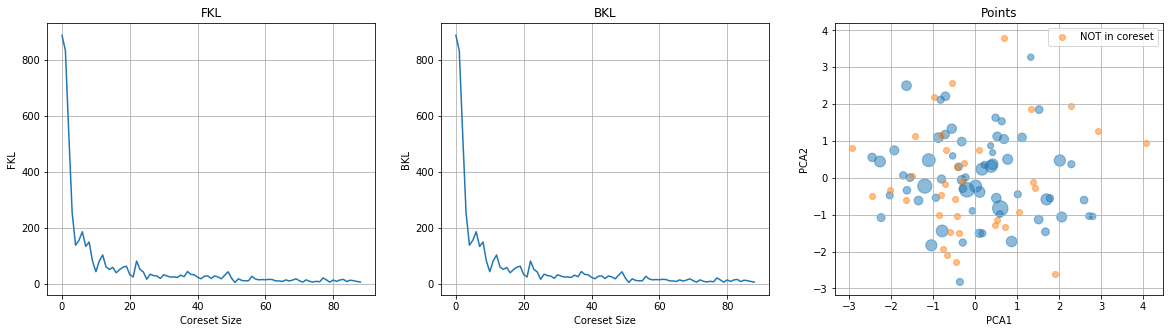

In [164]:
plot_results(fkl, bkl, x, I, w)

#### 1.1.2. Estimated norm

In [165]:
fkl = []
bkl = []

for i in range(1, 90):
    sbis = SensitivityBasedIS(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = sbis.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

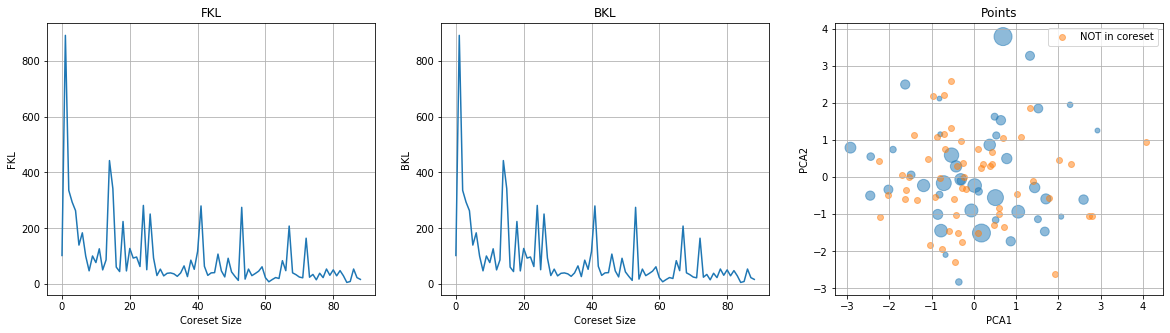

In [166]:
plot_results(fkl, bkl, x, I, w)

### 1.2. Sensitivity-Based FW

#### 1.2.1. True (Fisher) norm

In [167]:
fkl = []
bkl = []

for i in range(1, 90):
    sbfw = SensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

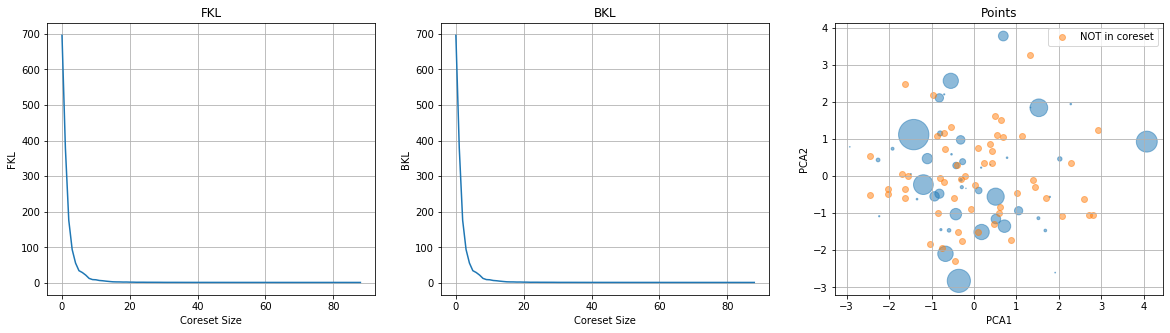

In [168]:
plot_results(fkl, bkl, x, I, w)

#### 1.2.2. Estimated norm

In [169]:
fkl = []
bkl = []

for i in range(1, 90):
    sbfw = SensitivityBasedFW(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": int(0.3 * len(x))}
    w, I = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

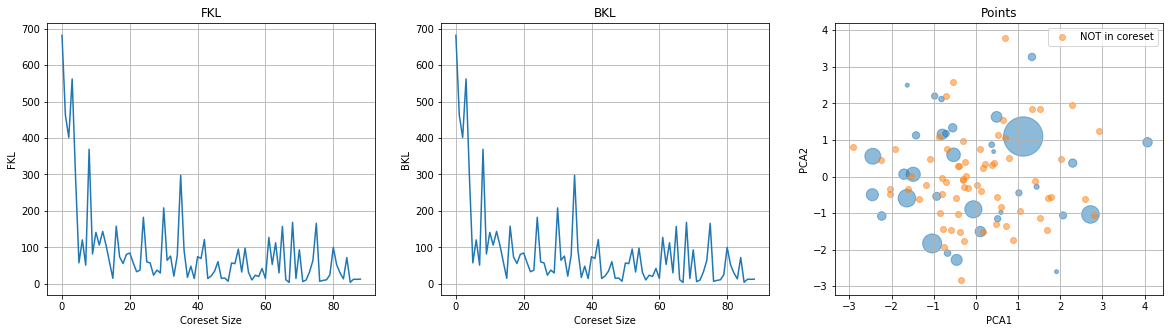

In [170]:
plot_results(fkl, bkl, x, I, w)

### 1.3. GIGA

#### 1.3.1. True (Fisher) norm

None

#### 1.3.2. Estimated norm

In [177]:
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 1000, norm = "2", MCMC_subs_size = 100)

In [178]:
fkl = []
bkl = []

for i in range(1, 90):
    giga = GIGA(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 1000,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

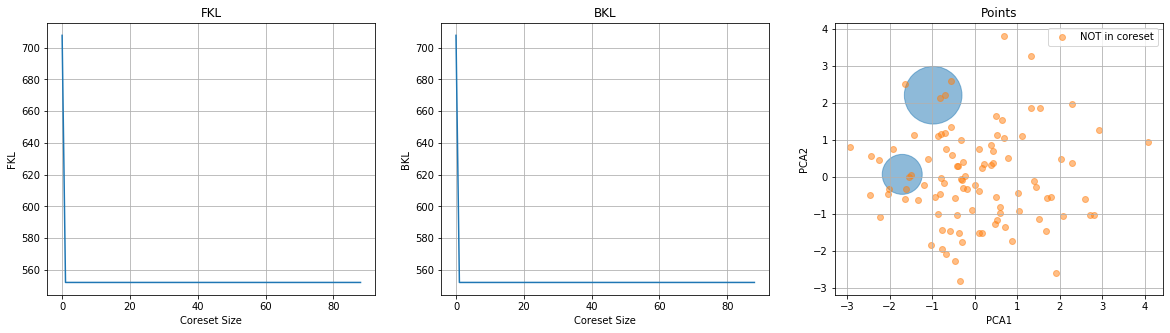

In [179]:
plot_results(fkl, bkl, x, I, w)

### 1.4. SparseVI

#### 1.4.1. True (Fisher) norm

In [184]:
fkl = []
bkl = []

for i in range(1, 90):
    def log_posterior(params, X, y, weights):
        return np.sum(log_likelihood(params, X, y, weights))

    svi = SparseVI(x)
    na = {"log_likelihood": log_likelihood,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(2 * d),
          "S": 150,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC"}

    w, I = svi.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                   norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

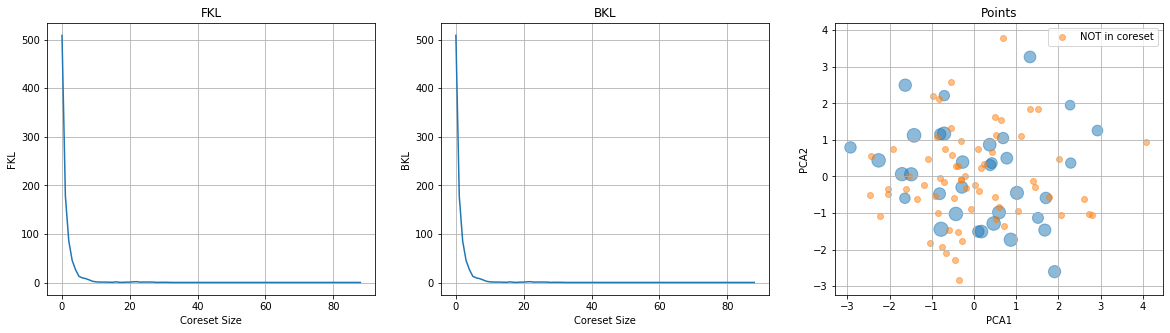

In [185]:
plot_results(fkl, bkl, x, I, w)

#### 1.4.2. Estimated norm

In [182]:
fkl = []
bkl = []

for i in range(1, 90):
    def log_posterior(params, X, y, weights):
        return np.sum(log_likelihood(params, X, y, weights))

    svi = SparseVI(x)
    na = {"log_likelihood": log_likelihood,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(2 * d),
          "S": 150,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC"}

    w, I = svi.run(k = i, likelihood_gram_matrix = None, 
                   norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

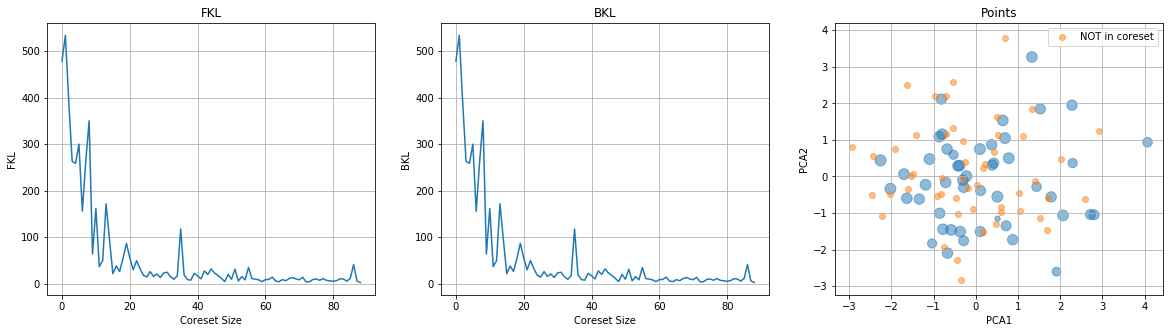

In [183]:
plot_results(fkl, bkl, x, I, w)

### 1.5. Iterative Hard Thresholding

In [6]:
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 1000, norm = "2", MCMC_subs_size = 100)

In [7]:
fkl = []

for i in range(1, 90):
    sbis = IHT(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = sbis.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)

    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))

TypeError: list indices must be integers or slices, not list

In [14]:
I

[0]

---
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from non_iterative import SensitivityBasedIS
from gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL
from metrics import gaussian_KL

## 1. Multivariate Gaussian

$$
\mu \in \mathbb{R}^D \sim \mathcal{N}(0, 1)
$$

$$
X_{n \times d} \sim \mathcal{N}(\mu, 1)
$$

In [2]:
# Generate Data
N = 100
d = 20

np.random.seed(123)

# Mean value
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# X_{n x d}
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Start values
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))

# Likelihood exact gram matrix
likelihood_gram_matrix = fisher_norm_under_true_gaussian_posterior(x.T, x.T, mu_0, N)

def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

print(f"x: {x.shape}")
print(f"mu: {mu_0.shape}")

x: (100, 20)
mu: (20, 1)


In [3]:
from non_iterative import SensitivityBasedIS
from iterative_with_convexification import SensitivityBasedFW
from iterative_no_convexification import SparseVI

### 1.1. IS with different norms

In [9]:
norms = ["uniform", "2", "F"]
apr = ["Laplace", "MCMC"]

fkls = []
bkls = []

for n in range(len(norms)):
    for k in range(len(apr)):
        print(f"{n}-{k}")
        fkl = []
        bkl = []
        for i in range(1, 90):
            sbis = SensitivityBasedIS(x)
            
            na = {"log_likelihood": log_likelihood,
              "log_likelihood_start_value": np.ones(2 * d),
              "S": 150,
              "log_likelihood_gradient": grad_log_likelihood,
              "approx": apr[k],
              "num_clusters": 3,
              "R": 1,
              "MCMC_subs_size": 30}
            
            w, I = sbis.run(k = i, likelihood_gram_matrix = None, norm = norms[n], norm_attributes = na)

            # Calculate posterior approximation
            sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
            mu_hat = sigma_hat @ (mu_0 + x.T @ w)

            fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
            bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
            
        fkls.append(fkl)
        bkls.append(bkl)

0-0
0-1
1-0
1-1
2-0
2-1


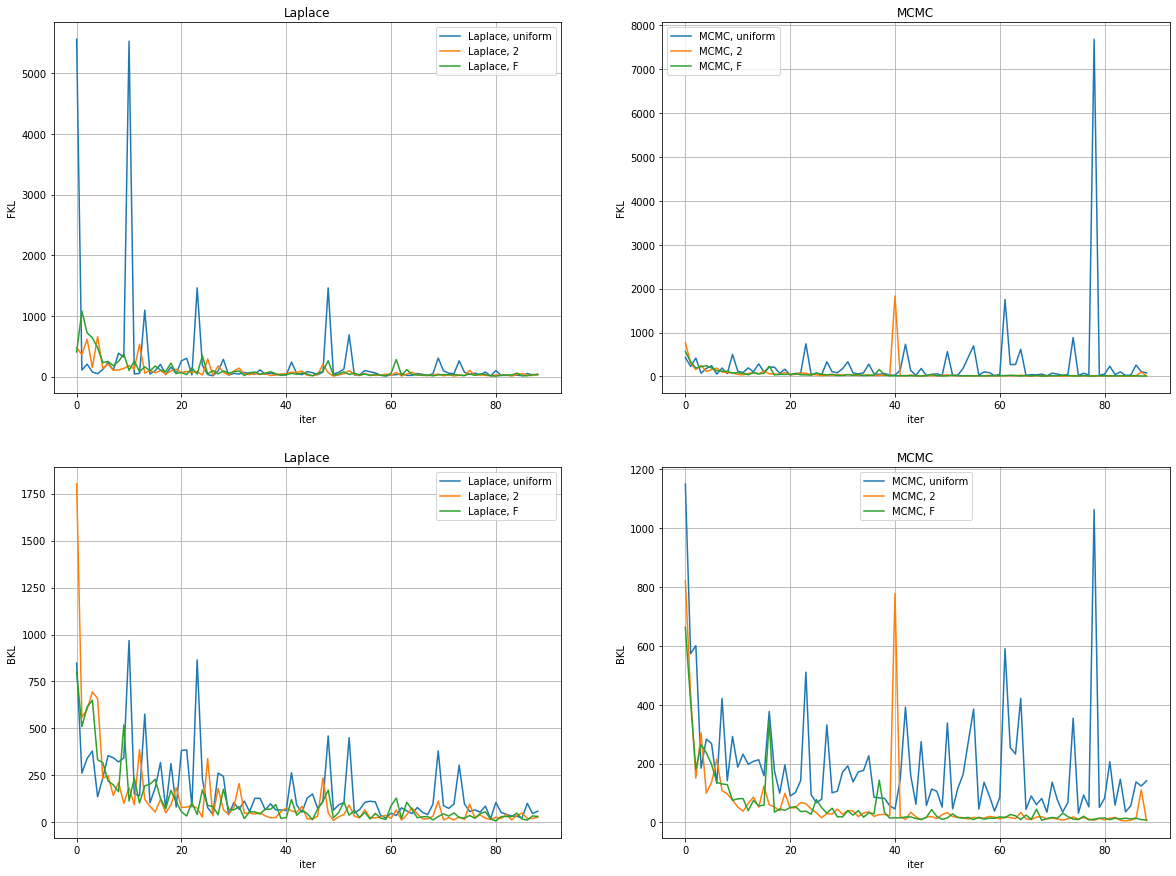

In [19]:
fig, ax = plt.subplots(2, 2, figsize = (20, 15))

ax[0, 0].plot(fkls[0], label = "Laplace, uniform")
ax[0, 0].plot(fkls[2], label = "Laplace, 2")
ax[0, 0].plot(fkls[4], label = "Laplace, F")
ax[0, 0].set_ylabel("FKL")
ax[0, 0].set_xlabel("iter")
ax[0, 0].set_title("Laplace")

ax[0, 1].plot(fkls[1], label = "MCMC, uniform")
ax[0, 1].plot(fkls[3], label = "MCMC, 2")
ax[0, 1].plot(fkls[5], label = "MCMC, F")
ax[0, 1].set_ylabel("FKL")
ax[0, 1].set_xlabel("iter")
ax[0, 1].set_title("MCMC")

ax[1, 0].plot(bkls[0], label = "Laplace, uniform")
ax[1, 0].plot(bkls[2], label = "Laplace, 2")
ax[1, 0].plot(bkls[4], label = "Laplace, F")
ax[1, 0].set_ylabel("BKL")
ax[1, 0].set_xlabel("iter")
ax[1, 0].set_title("Laplace")

ax[1, 1].plot(bkls[1], label = "MCMC, uniform")
ax[1, 1].plot(bkls[3], label = "MCMC, 2")
ax[1, 1].plot(bkls[5], label = "MCMC, F")
ax[1, 1].set_ylabel("BKL")
ax[1, 1].set_xlabel("iter")
ax[1, 1].set_title("MCMC")

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

ax[0, 0].grid()
ax[0, 1].grid()
ax[1, 0].grid()
ax[1, 1].grid()

### 1.2. FW with different norms

In [5]:
norms = ["2", "F"]
apr = ["Laplace", "MCMC"]

fkls = []
bkls = []

for n in range(len(norms)):
    for k in range(len(apr)):
        print(f"{n}-{k}")
        fkl = []
        bkl = []
        for i in range(1, 90):
            sbis = SensitivityBasedFW(x)
            
            na = {"log_likelihood": log_likelihood,
              "log_likelihood_start_value": np.ones(2 * d),
              "S": 150,
              "log_likelihood_gradient": grad_log_likelihood,
              "approx": apr[k],
              "num_clusters": 3,
              "R": 1,
              "MCMC_subs_size": 30}
            
            w, I = sbis.run(k = i, likelihood_gram_matrix = None, norm = norms[n], norm_attributes = na)

            # Calculate posterior approximation
            sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
            mu_hat = sigma_hat @ (mu_0 + x.T @ w)

            fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
            bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
            
        fkls.append(fkl)
        bkls.append(bkl)

0-0
0-1
1-0
1-1


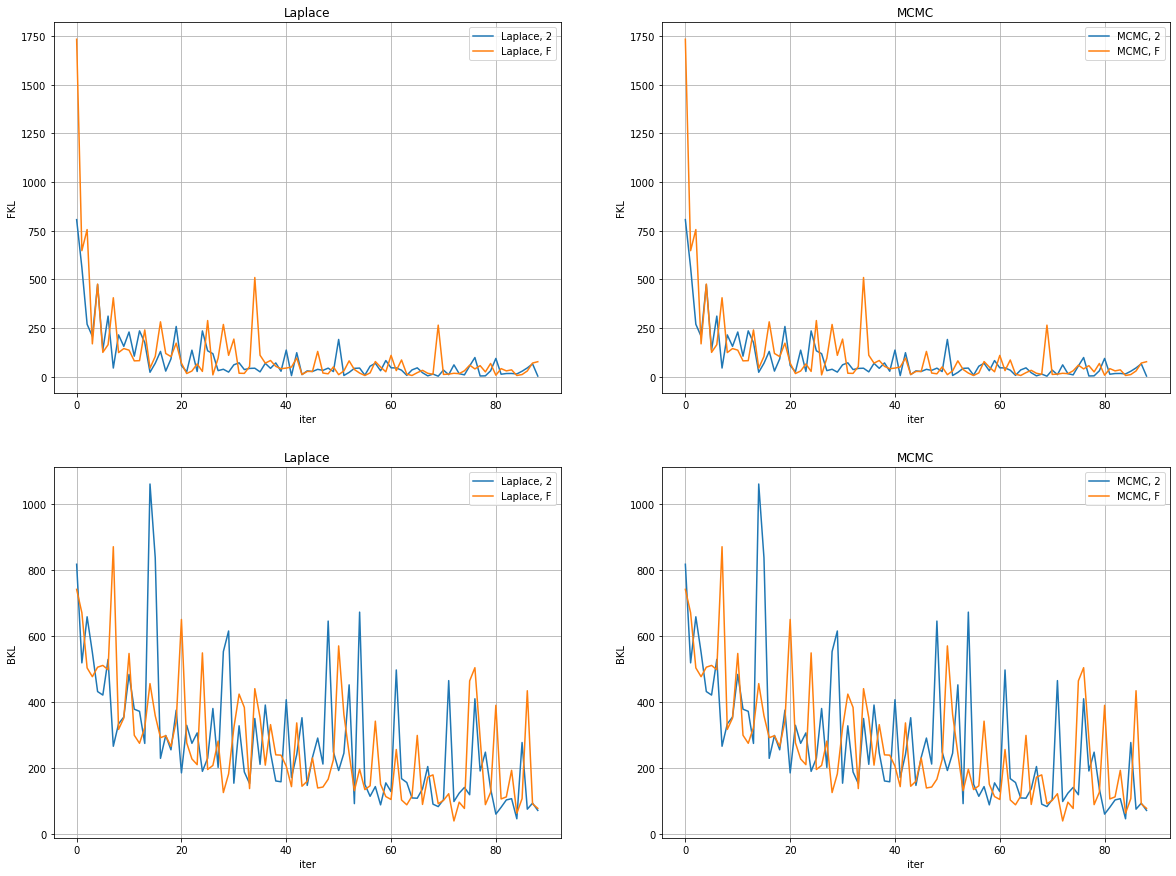

In [6]:
fig, ax = plt.subplots(2, 2, figsize = (20, 15))

ax[0, 0].plot(fkls[0], label = "Laplace, 2")
ax[0, 0].plot(fkls[2], label = "Laplace, F")
ax[0, 0].set_ylabel("FKL")
ax[0, 0].set_xlabel("iter")
ax[0, 0].set_title("Laplace")

ax[0, 1].plot(fkls[0], label = "MCMC, 2")
ax[0, 1].plot(fkls[2], label = "MCMC, F")
ax[0, 1].set_ylabel("FKL")
ax[0, 1].set_xlabel("iter")
ax[0, 1].set_title("MCMC")

ax[1, 0].plot(bkls[1], label = "Laplace, 2")
ax[1, 0].plot(bkls[3], label = "Laplace, F")
ax[1, 0].set_ylabel("BKL")
ax[1, 0].set_xlabel("iter")
ax[1, 0].set_title("Laplace")

ax[1, 1].plot(bkls[1], label = "MCMC, 2")
ax[1, 1].plot(bkls[3], label = "MCMC, F")
ax[1, 1].set_ylabel("BKL")
ax[1, 1].set_xlabel("iter")
ax[1, 1].set_title("MCMC")

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

ax[0, 0].grid()
ax[0, 1].grid()
ax[1, 0].grid()
ax[1, 1].grid()

### 1.3. FW with true vs estimated posterior

In [9]:
norms = ["F"]
apr = ["Laplace", "MCMC"]

fkls = []
bkls = []

for n in range(len(norms)):
    for k in range(len(apr)):
        print(f"{n}-{k}")
        fkl = []
        bkl = []
        for i in range(1, 90):
            sbis = SensitivityBasedFW(x)
            
            na = {"log_likelihood": log_likelihood,
              "log_likelihood_start_value": np.ones(2 * d),
              "S": 150,
              "log_likelihood_gradient": grad_log_likelihood,
              "approx": apr[k],
              "num_clusters": 3,
              "R": 1,
              "MCMC_subs_size": 30}
            
            w, I = sbis.run(k = i, likelihood_gram_matrix = None, norm = norms[n], norm_attributes = na)

            # Calculate posterior approximation
            sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
            mu_hat = sigma_hat @ (mu_0 + x.T @ w)

            fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
            bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))
            
        fkls.append(fkl)
        bkls.append(bkl)

0-0
0-1


In [10]:
fkl = []
bkl = []

for i in range(1, 90):
        sbis = SensitivityBasedFW(x)

        na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(2 * d),
          "S": 150,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": apr[k],
          "num_clusters": 3,
          "R": 1,
          "MCMC_subs_size": 30}

        w, I = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, 
                        norm = "F", norm_attributes = na)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w)

        fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
        bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

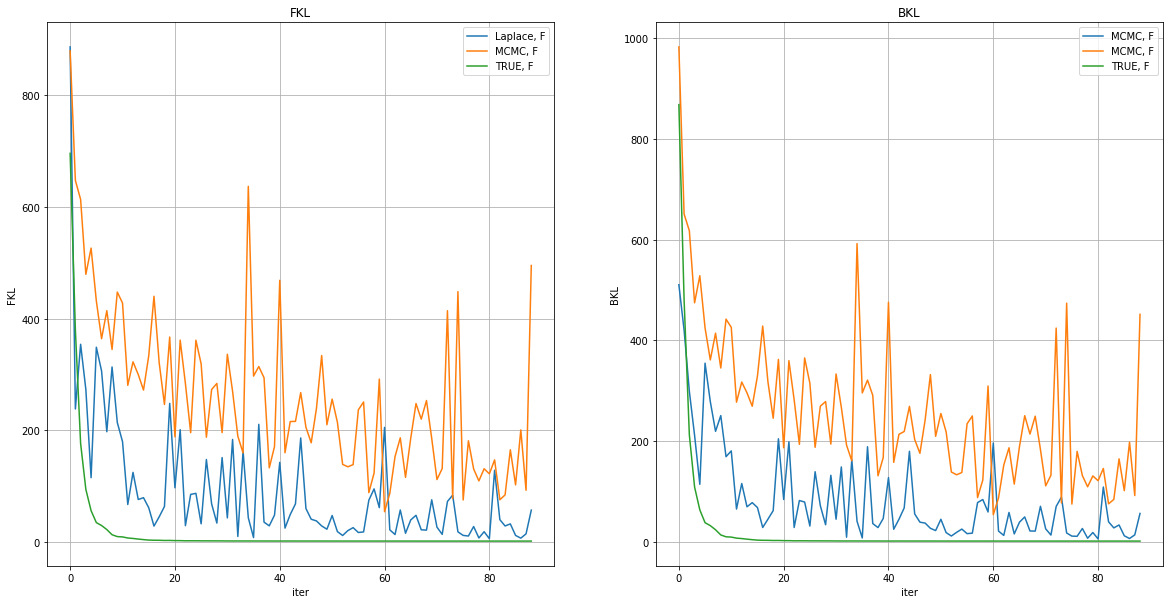

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

ax[0].plot(fkls[0], label = "Laplace, F")
ax[0].plot(fkls[1], label = "MCMC, F")
ax[0].plot(fkl, label = "TRUE, F")
ax[0].set_ylabel("FKL")
ax[0].set_xlabel("iter")
ax[0].set_title("FKL")

ax[1].plot(bkls[0], label = "MCMC, F")
ax[1].plot(bkls[1], label = "MCMC, F")
ax[1].plot(bkl, label = "TRUE, F")
ax[1].set_ylabel("BKL")
ax[1].set_xlabel("iter")
ax[1].set_title("BKL")

ax[0].legend()
ax[1].legend()

ax[0].grid()
ax[1].grid()

### 1.4. GIGA with different vector lengths

* S = 500

In [190]:
np.random.seed(123)
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 500, norm = "2", MCMC_subs_size = 100)

In [191]:
fkl = []
bkl = []

for i in range(1, 90):
    giga = GIGA(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 1000,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

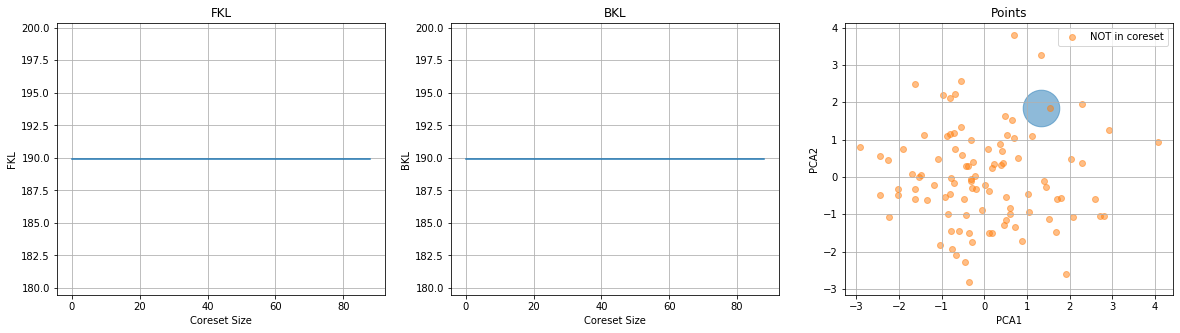

In [192]:
plot_results(fkl, bkl, x, I, w)

* S = 1000

In [193]:
np.random.seed(123)
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 1000, norm = "2", MCMC_subs_size = 100)

In [194]:
fkl = []
bkl = []

for i in range(1, 90):
    giga = GIGA(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 1000,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

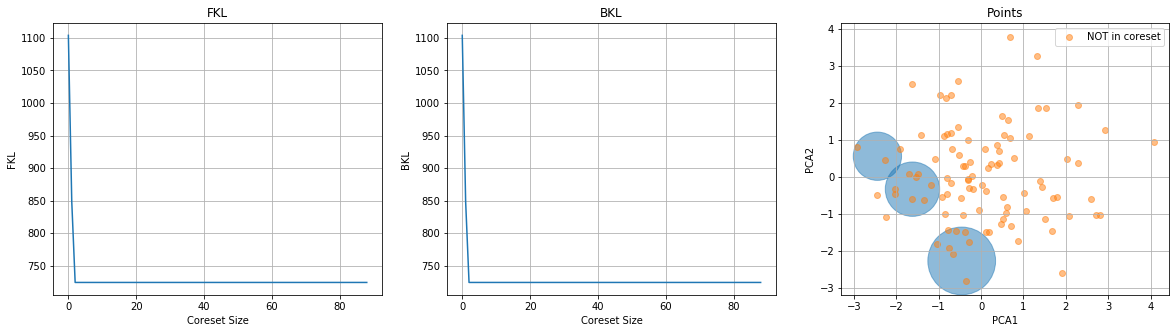

In [195]:
plot_results(fkl, bkl, x, I, w)

* S = 5000

In [196]:
np.random.seed(123)
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 5000, norm = "2", MCMC_subs_size = 100)

In [197]:
fkl = []
bkl = []

for i in range(1, 90):
    giga = GIGA(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 1000,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

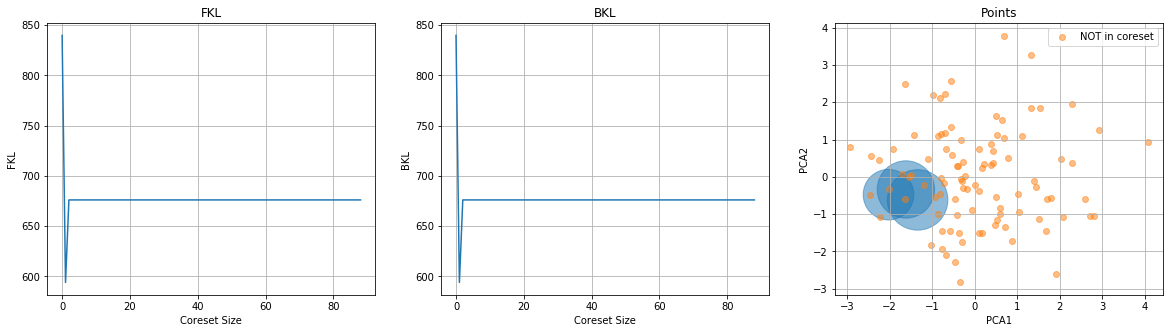

In [198]:
plot_results(fkl, bkl, x, I, w)

* S = 10000

In [199]:
np.random.seed(123)
from approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 10000, norm = "2", MCMC_subs_size = 100)

In [200]:
fkl = []
bkl = []

for i in range(1, 90):
    giga = GIGA(x)
    na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 1000,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "Laplace",
      "MCMC_subs_size": 100}
    w, I = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w)

    fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
    bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

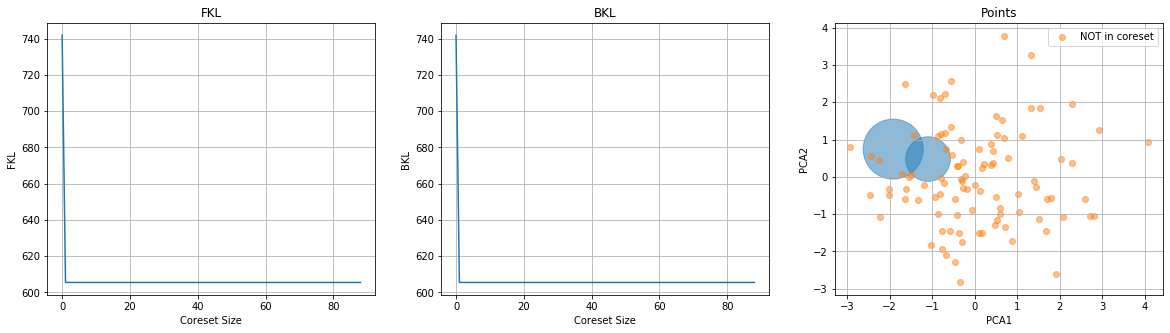

In [201]:
plot_results(fkl, bkl, x, I, w)

### 1.5 Comparison of all algorithms

In [245]:
fkl = np.zeros((29, 4))
bkl = np.zeros((29, 4))

na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 500,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "MCMC",
      "MCMC_subs_size": 100,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(2 * d)}

for i in range(1, 30):
    sbis = SensitivityBasedIS(x)
    sbfw = SensitivityBasedFW(x)
    giga = GIGA(x)
    svi = SparseVI(x)
    w1, I1 = sbis.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    w3, I3 = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    w4, I4 = svi.run(k = i, likelihood_gram_matrix = None, 
                     norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w1)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w1)

    fkl[i-1, 0] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[i-1, 0] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w2)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w2)

    fkl[i-1, 1] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[i-1, 1] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w3)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w3)

    fkl[i-1, 2] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[i-1, 2] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w4)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w4)

    fkl[i-1, 3] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[i-1, 3] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)

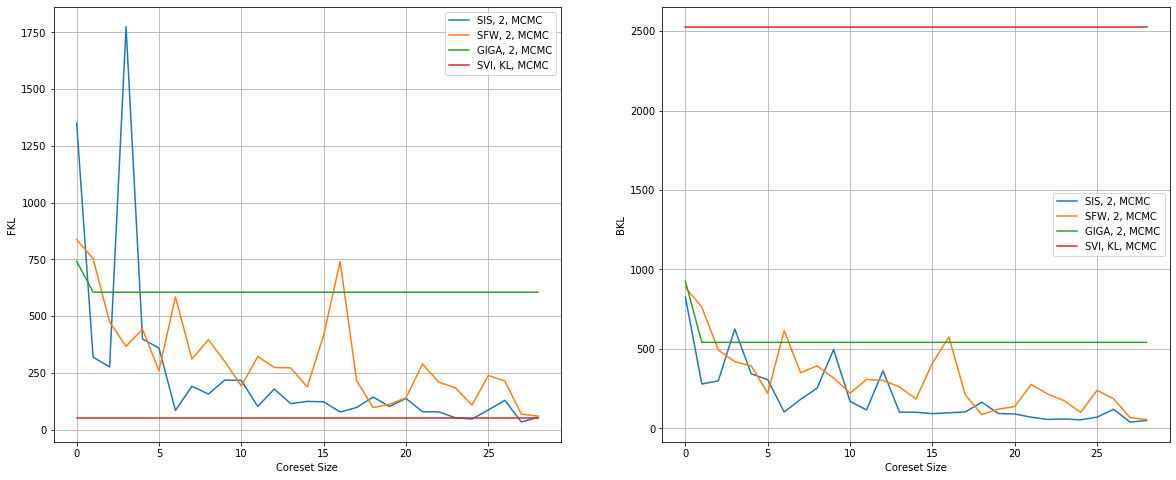

In [246]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(fkl[:, 0], label = 'SIS, 2, MCMC')
ax[0].plot(fkl[:, 1], label = 'SFW, 2, MCMC')
ax[0].plot(fkl[:, 2], label = 'GIGA, 2, MCMC')
ax[0].plot(fkl[:, 3], label = 'SVI, KL, MCMC')
ax[0].legend()
ax[0].set_xlabel("Coreset Size")
ax[0].set_ylabel("FKL")
ax[0].grid()

ax[1].plot(bkl[:, 0], label = 'SIS, 2, MCMC')
ax[1].plot(bkl[:, 1], label = 'SFW, 2, MCMC')
ax[1].plot(bkl[:, 2], label = 'GIGA, 2, MCMC')
ax[1].plot(bkl[:, 3], label = 'SVI, KL, MCMC')
ax[1].legend()
ax[1].set_xlabel("Coreset Size")
ax[1].set_ylabel("BKL")
ax[1].grid()

## 2. Gaussian Mixture

In [217]:
# Generate Data
N = 100
d = 20

np.random.seed(123)

# Mean value
theta1 = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d)) # mean = 0
theta2 = np.random.multivariate_normal(mean = np.ones(d) * 4, cov = np.identity(d)) # mean = 4

# X_{n x d}
x1 = np.random.multivariate_normal(mean = theta1, cov = np.identity(d), size = N)
x2 = np.random.multivariate_normal(mean = theta2, cov = np.identity(d), size = N)
x = np.vstack([x1, x2])

# Start values
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))

# Likelihood exact gram matrix
likelihood_gram_matrix = fisher_norm_under_true_gaussian_posterior(x.T, x.T, mu_0, N)

def log_likelihood(params, X, y, weights):
    pi1 = params[0]
    mu1 = params[1:(d+1)].reshape(-1, 1)
    sigma1 = np.diag(params[d+1:2*d+1].reshape(-1, 1)[:, 0])
    mu2 = params[2*d+1:3*d+1].reshape(-1, 1)
    sigma2 = np.diag(params[3*d+1:].reshape(-1, 1)[:, 0])
    return pi1 * np.diag(gaussian_multivariate_log_likelihood(X.T, mu1, sigma1)).reshape(-1, 1) +\
            (1-pi1) * np.diag(gaussian_multivariate_log_likelihood(X.T, mu2, sigma2)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

print(f"x: {x.shape}")
print(f"mu: {mu_0.shape}")

x: (200, 20)
mu: (20, 1)


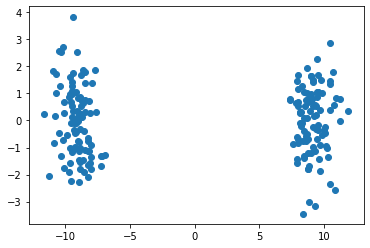

In [218]:
pca = PCA(n_components = 2)
vecs = pca.fit_transform(x)
plt.scatter(vecs[:, 0], vecs[:, 1])

In [207]:
fkl = []
bkl = []

for i in range(1, 20):
        print(i)
        sbfw = SensitivityBasedFW(x)

        na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(1 + 4 * d),
          "S": 150,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "Laplace",
          "num_clusters": 3,
          "R": 1,
          "MCMC_subs_size": 30}

        w, I = sbfw.run(k = i, likelihood_gram_matrix = None, 
                        norm = "2", norm_attributes = na)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w)

        fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
        bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


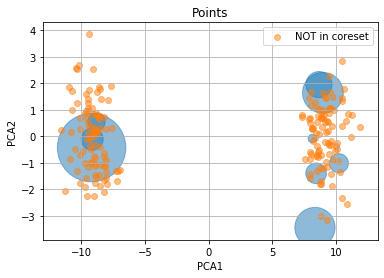

In [210]:
plot_points(x, I, w)

In [224]:
fkl = []
bkl = []

for i in range(1, 20):
        print(i)
        svi = SparseVI(x)

        na = {"log_likelihood": log_likelihood,
          "log_likelihood_start_value": np.ones(1 + 4 * d),
          "S": 150,
          "log_likelihood_gradient": grad_log_likelihood,
          "approx": "MCMC",
          "num_clusters": 3,
          "R": 1,
          "MCMC_subs_size": 30,
          "log_posterior": log_posterior,
          "log_posterior_start_value": np.ones(1 + 4 * d)}

        w, I = svi.run(k = i, likelihood_gram_matrix = None, 
                   norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)

        # Calculate posterior approximation
        sigma_hat = 1 / (1 + np.sum(w)) * np.identity(d)
        mu_hat = sigma_hat @ (mu_0 + x.T @ w)

        fkl.append(gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat))
        bkl.append(gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


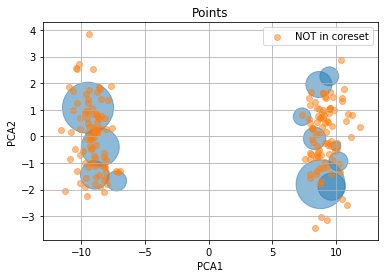

In [225]:
plot_points(x, I, w)